In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

In [2]:
# load the dataset
df = pd.read_csv('5_hotel_reservations.csv')

# Data Dictionary

* **no_of_weekend_nights**: Number of weekend nights (Saturday or Sunday) the guest stayed or booked to stay at the hotel  
* **no_of_week_nights**: Number of week nights (Monday to Friday) the guest stayed or booked to stay at the hotel  
* **type_of_meal_plan**: Type of meal plan booked by the customer  
* **required_car_parking_space**: Does the customer require a car parking space? (0 - No, 1 - Yes)  
* **room_type_reserved**: Type of room reserved by the customer. The values are ciphered (encoded) by INN Hotels  
* **lead_time**: Number of days between the date of booking and the arrival date  
* **arrival_year**: Year of arrival date  
* **arrival_month**: Month of arrival date  
* **arrival_date**: Date of the month  
* **market_segment_type**: Market segment designation  
* **repeated_guest**: Is the customer a repeated guest? (0 - No, 1 - Yes)  
* **no_of_previous_cancellations**: Number of previous bookings that were canceled by the customer prior to the current booking  
* **no_of_previous_bookings_not_canceled**: Number of previous bookings not canceled by the customer prior to the current booking  
* **avg_price_per_room**: Average price per day of the reservation; prices of the rooms are dynamic (in euros)  
* **no_of_special_requests**: Total number of special requests made by the customer (e.g. high floor, view from the room, etc)  
* **booking_status**: Flag indicating if the booking was canceled or not  
* **date_ymd**: Date of arrival in YYYY-MM-DD format (constructed from arrival fields)  
* **was_capped**: Indicates if the arrival_date was capped to the last valid day of the month (1 - Yes, 0 - No)  
* **year**: Extracted year from date_ymd (used for grouping or plotting)  
* **month**: Extracted month from date_ymd (used for grouping or plotting)  
* **weekday**: Name of the weekday (e.g. Monday, Tuesday) corresponding to date_ymd  
* **weekday_num**: Numerical representation of the weekday (0 = Monday, 6 = Sunday)  
* **stay_duration_status**: Classification of total stay as either "short_stay" or "long_stay"  
* **total_previous_bookings**: Total of previous cancellations and non-cancellations by the customer  
* **cancel_rate**: Ratio of previous cancellations to total previous bookings  
* **total_stay_duration**: Total number of nights stayed (week_nights + weekend_nights)


In [3]:
print("\n--- Dataset Head (first 5 rows) ---")
print(df.head())

print("\n--- Dataset Info (data types and non-null counts) ---")
df.info()

print("\n--- Dataset Description (summary statistics) ---")
print(df.describe())

print("\n--- Check for Missing Values ---")
print(df.isnull().sum())



--- Dataset Head (first 5 rows) ---
  Booking_ID  no_of_adults  no_of_children  no_of_weekend_nights  \
0   INN00001             2               0                     1   
1   INN00002             2               0                     2   
2   INN00003             1               0                     2   
3   INN00004             2               0                     0   
4   INN00005             2               0                     1   

   no_of_week_nights type_of_meal_plan  required_car_parking_space  \
0                  2       Meal Plan 1                           0   
1                  3      Not Selected                           0   
2                  1       Meal Plan 1                           0   
3                  2       Meal Plan 1                           0   
4                  1      Not Selected                           0   

  room_type_reserved  lead_time  arrival_year  arrival_month  arrival_date  \
0        Room_Type 1        224          2017          

# Part 1: Exploratory Data Analysis
* There are 36,275 rows and 21 columns in the Hotel Reservation dataset
* It could be used for market segmentation, i.e. to know where to focus specific campaigns or which aspects of the business to improve to minimize cancelations

#### 1. Clean up or concatenate date field
   * Since in the data set the date is divided into 'arrival_year', 'arrival_month', and 'arrival_date', I included an additional field to capture the whole date in y-m-d format
   * After that, I had to apply a cap day to the new 'date_ymd' field -- specifically for February 2018 -- because it had days up to 29th despite 2018 not being a leap year 
#### 2. Get min max of years/date covered
   * The dataset runs from 2017-07-01 to 2018-12-31
   * This means the reservation data is not completely represented yearly, we cannot fully compare 2017 vs 2018 YoY
   * We can get monthly data instead, either year month or just monthly cumulative (but still note that some months are represented in only one year and some are in both 2017 and 2018 data)   

In [4]:
import pandas as pd
import calendar
from datetime import datetime

# Sample input columns
# df["arrival_year"], df["arrival_month"], df["arrival_date"]

def cap_day_to_month(row):
    year = int(row["arrival_year"])
    month = int(row["arrival_month"])
    day = int(row["arrival_date"])

    # Get the last valid day for this year/month
    max_day = calendar.monthrange(year, month)[1]
    safe_day = min(day, max_day)

    try:
        return datetime(year, month, safe_day)
    except:
        return pd.NaT  # in case year/month is invalid too

# Apply row-wise to construct corrected date
df["date_ymd"] = df.apply(cap_day_to_month, axis=1)

# Optional: flag if the original date was capped
df["was_capped"] = df["arrival_date"] > df["date_ymd"].dt.day


In [5]:
df[df["was_capped"] == True]


,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,...,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status,date_ymd,was_capped
2626,INN02627,2,0,1,5,Meal Plan 1,0,Room_Type 1,104,2018,...,29,Online,1,1,0,61.43,0,Canceled,2018-02-28,True
3677,INN03678,1,0,1,3,Meal Plan 1,0,Room_Type 1,21,2018,...,29,Online,0,0,0,102.05,0,Canceled,2018-02-28,True
5600,INN05601,2,0,1,3,Meal Plan 1,0,Room_Type 1,24,2018,...,29,Offline,0,0,0,45.50,0,Not_Canceled,2018-02-28,True
6343,INN06344,1,0,1,1,Meal Plan 1,0,Room_Type 1,117,2018,...,29,Offline,0,0,0,76.00,0,Not_Canceled,2018-02-28,True
7648,INN07649,2,1,1,5,Meal Plan 1,0,Room_Type 1,35,2018,...,29,Online,0,0,0,98.10,1,Canceled,2018-02-28,True
8000,INN08001,2,2,1,3,Meal Plan 1,0,Room_Type 6,3,2018,...,29,Online,0,0,0,183.00,1,Not_Canceled,2018-02-28,True
8989,INN08990,1,0,1,2,Meal Plan 1,0,Room_Type 1,117,2018,...,29,Offline,0,0,0,76.00,0,Not_Canceled,2018-02-28,True
9153,INN09154,2,2,1,3,Meal Plan 1,0,Room_Type 6,3,2018,...,29,Online,0,0,0,189.75,0,Not_Canceled,2018-02-28,True
9245,INN09246,2,0,1,3,Meal Plan 1,0,Room_Type 4,15,2018,...,29,Online,0,0,0,85.55,1,Not_Canceled,2018-02-28,True
9664,INN09665,1,0,1,0,Meal Plan 1,0,Room_Type 4,21,2018,...,29,Online,0,0,0,117.00,0,Not_Canceled,2018-02-28,True


In [6]:
min(df['date_ymd'])

Timestamp('2017-07-01 00:00:00')

In [7]:
max(df['date_ymd'])

Timestamp('2018-12-31 00:00:00')

#### 3. Get Total Booking Per Month

##### Monthly Bookings (Cumulative)
* October has the higest bookings, suggesting a peak season
* The trend shows a gradual increase in bookings from January to October which rapidly drops during November and December

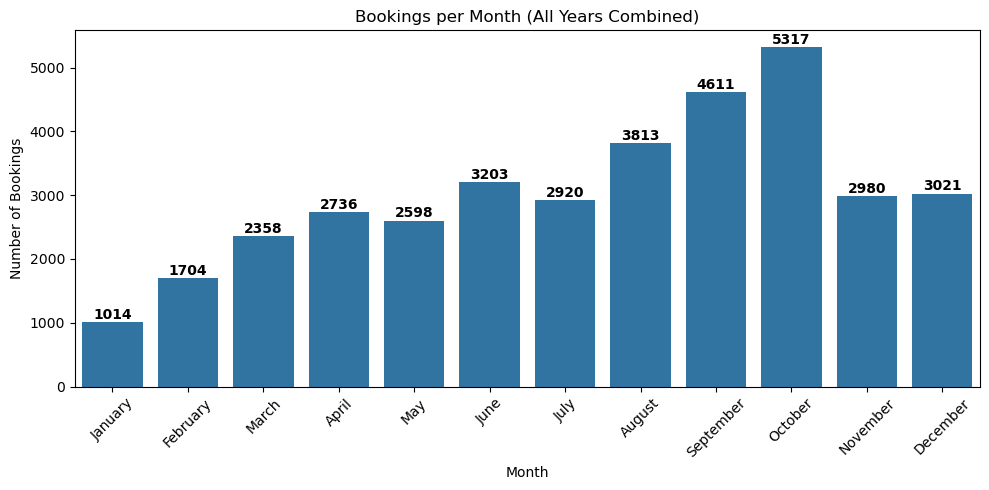

In [8]:
# Count bookings per month regardless of year
monthly_counts = df['arrival_month'].value_counts().sort_index()

# Map month numbers to names
month_names = {
    1: 'January', 2: 'February', 3: 'March', 4: 'April',
    5: 'May', 6: 'June', 7: 'July', 8: 'August',
    9: 'September', 10: 'October', 11: 'November', 12: 'December'
}
monthly_counts.index = monthly_counts.index.map(month_names)

# Plot
plt.figure(figsize=(10, 5))
ax = sns.barplot(x=monthly_counts.index, y=monthly_counts.values)
plt.title('Bookings per Month (All Years Combined)')
plt.xlabel('Month')
plt.ylabel('Number of Bookings')
plt.xticks(rotation=45)

# Add value labels on top of bars
for i, value in enumerate(monthly_counts.values):
    ax.text(i, value + 5, str(value), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()



##### Monthly Bookings from 2017-2018
* 2018 has more bookings when comparing same timeframe July to December
* Months with the most bookings are June and Oct 2018, and the ones with the least are July and November 2017
* In both years, bookings drastically decrease from October to November
* Some assumptions:
  * the hotel may have been new in 2017 hence the fewer bookings, but since both years seem to follow the same trend there could be a peak season in the region where it is located
  * Possible countries (since currency is in euro): Greece, Spain, or somewhere else in Southern Europe or the Mediterranean, or in Germany for Oktoberfest

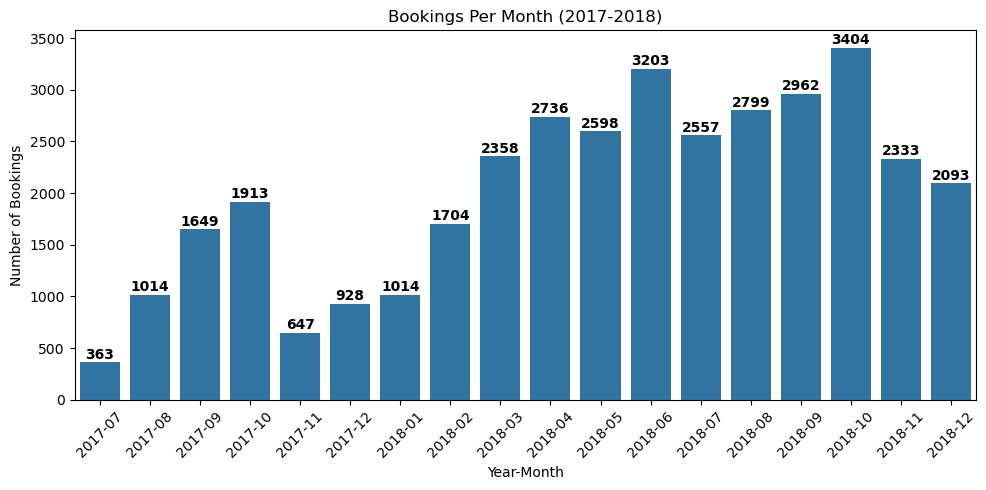

In [9]:

# Ensure the index is datetime
df['date_ymd'] = pd.to_datetime(df['date_ymd'])

#Create year and month columns
df['year'] = df['date_ymd'].dt.year
df['month'] = df['date_ymd'].dt.month

#Group by year and month
grouped_yearmonth = df.groupby(['year','month']).size()

#Optional for nicer labels
grouped_yearmonth.index = [f"{year}-{month:02}" for year, month in grouped_yearmonth.index]

# Plot
plt.figure(figsize=(10,5))
ax = sns.barplot(x=grouped_yearmonth.index, y=grouped_yearmonth.values)
plt.title('Bookings Per Month (2017-2018)')
plt.xlabel('Year-Month')
plt.ylabel('Number of Bookings')
plt.xticks(rotation = 45)

# Add value labels on top of bars
for i, value in enumerate(grouped_yearmonth.values):
    ax.text(i, value + 5, str(value), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()



#### 4. Booking Per Day of the Week
* Which day has the most bookings, more specifically which days have the most arrivals?
  * Sunday has the most number of bookings followed by Saturday and Monday, suggesting either a weekend (Sun/Sat) or early week (Mon) start are preferred

In [10]:
df["weekday"] = df["date_ymd"].dt.day_name()
df["weekday_num"] = df["date_ymd"].dt.weekday


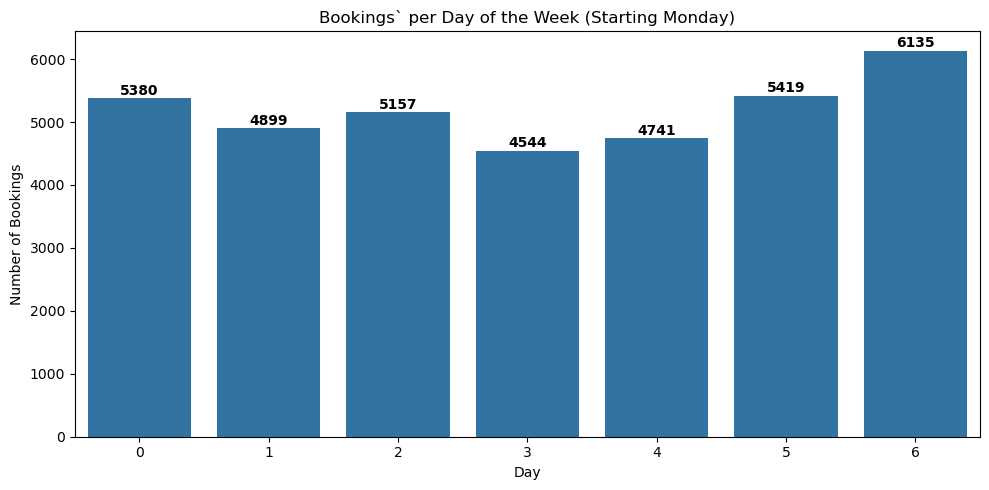

In [11]:


#Group by year and month
week_day = df.groupby('weekday_num').size().sort_index()

# Plot
plt.figure(figsize=(10,5))
ax = sns.barplot(x=week_day.index, y=week_day.values)

plt.title('Bookings` per Day of the Week (Starting Monday)')
plt.xlabel('Day')
plt.ylabel('Number of Bookings')
plt.xticks(rotation = 0)

# Add value labels on top of bars
for i, value in enumerate(week_day.values):
    ax.text(i, value + 5, str(value), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()



#### 5. How long do guests usually stay?
* In order to determine total length of stay, I made a field 'total_stay_duration' which added up total weekend nights and total weekday nights
* Average length of stay is **3 nights**
* I made another field to compare *long stay (> 7 days)* and *short stay (=< 7 days)*. As shown in the pie chart below, **98% of bookings are short stays** which is a significant portion of bookings. Promotions can be developed to increase sales related to short term stay, while also devising ways to encourage long term bookings if desired.

##### Total Length of Stay = total stay duration = no_of_weekend_nights + no_of_week_nights

In [12]:
df["total_stay_duration"] = df["no_of_weekend_nights"] + df["no_of_week_nights"]

In [13]:
#Average length of stay
df['total_stay_duration'].mean()

np.float64(3.0150241212956583)

In [14]:
#Average length of stay
df['total_stay_duration'].median()

3.0

##### Long Stay vs Short Stay

stay_duration_status: long_stay if total stay duration if > 7 days

In [15]:
df["stay_duration_status"] = np.where(
    df["total_stay_duration"].isna(),
    "unknown",
    np.where(df["total_stay_duration"] > 7, "long_stay", "short_stay")
)

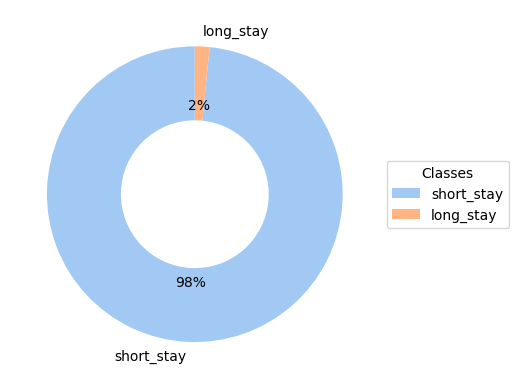

In [53]:
#Pie Chart for Long Stay vs Short Stay

data = df["stay_duration_status"].value_counts()
colors = sns.color_palette('pastel')

fig, ax = plt.subplots()

wedges, texts, autotexts = ax.pie(
    data,
    labels=data.index,
    colors=colors,
    startangle=90,
    autopct='%.0f%%',
    wedgeprops=dict(width=0.5)
)

ax.legend(handles = wedges, labels=list(data.index), title="Classes", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.show()

#### 6. How does lead time correlate with booking status? Does longer lead time equate to more cancellations?
* Identify cancellation rate based on previous cancellations and non-cancelations
    * **Cancelation Rate** = no_of_previous_cancellations/(no_of_previous_cancellations+no_of_previous_bookings_not_canceled)
* What is the average cancel rate?
* What is the average lead time?
* Using a scatterplot chart, identify if lead time and booking status have a significant correlation.

In [17]:
#total previous bookings
df["total_previous_bookings"] = df["no_of_previous_cancellations"]+df["no_of_previous_bookings_not_canceled"]

In [18]:
#df["cancel_rate"] = df["no_of_previous_cancellations"]/df["total_previous_bookings"]
#safe divide if with 0 values
df["cancel_rate"] = np.where(
    df["total_previous_bookings"] == 0,
    0,
    df["no_of_previous_cancellations"] / df["total_previous_bookings"]
)


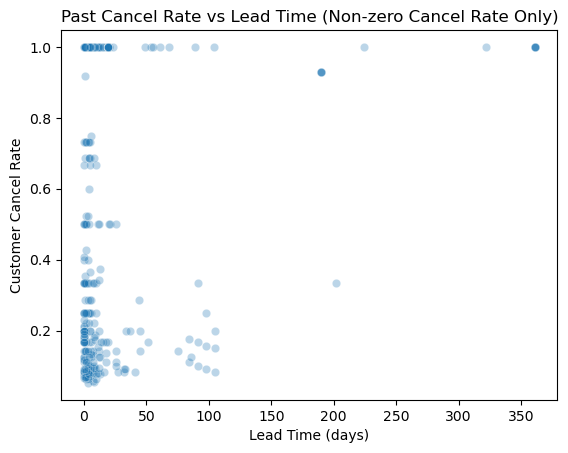

In [19]:
#scatterplot
# Filter to include only customers with non-zero cancel rate
filtered_df = df[df['cancel_rate'] > 0]

# Scatterplot with filtered data
sns.scatterplot(data=filtered_df, x='lead_time', y='cancel_rate', alpha=0.3)
plt.title('Past Cancel Rate vs Lead Time (Non-zero Cancel Rate Only)')
plt.xlabel('Lead Time (days)')
plt.ylabel('Customer Cancel Rate')
plt.show()


##### Lead Time vs Booking Status
* transform Booking Status to numerical categories

In [20]:
df["booking_status_num"] = np.where(
    df["booking_status"].isna(),
    "unknown",
    np.where(df["booking_status"] == 'Canceled', 1, 0)
)

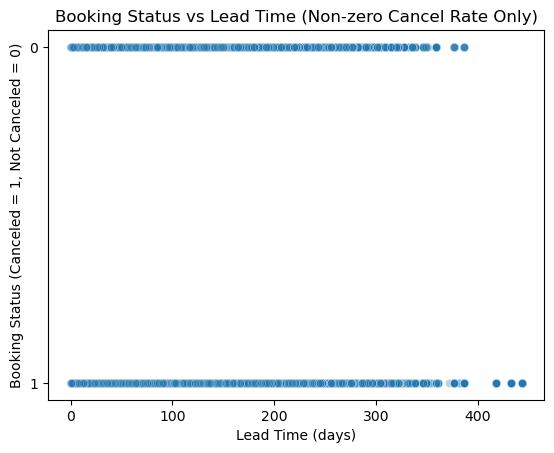

In [21]:
#scatterplot
# Filter to include only customers with non-zero cancel rate
#filtered_df = df[df['cancel_rate'] > 0]

# Scatterplot with filtered data
sns.scatterplot(data=df, x='lead_time', y='booking_status_num', alpha=0.3)
plt.title('Booking Status vs Lead Time (Non-zero Cancel Rate Only)')
plt.xlabel('Lead Time (days)')
plt.ylabel('Booking Status (Canceled = 1, Not Canceled = 0)')
plt.show()


In [22]:
print(df.columns)

Index(['Booking_ID', 'no_of_adults', 'no_of_children', 'no_of_weekend_nights',
       'no_of_week_nights', 'type_of_meal_plan', 'required_car_parking_space',
       'room_type_reserved', 'lead_time', 'arrival_year', 'arrival_month',
       'arrival_date', 'market_segment_type', 'repeated_guest',
       'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled',
       'avg_price_per_room', 'no_of_special_requests', 'booking_status',
       'date_ymd', 'was_capped', 'year', 'month', 'weekday', 'weekday_num',
       'total_stay_duration', 'stay_duration_status',
       'total_previous_bookings', 'cancel_rate', 'booking_status_num'],
      dtype='object')


#### 7. Do bookings done online have a higher chance of cancelation?

In [23]:
avg_prices = df.groupby('market_segment_type')['avg_price_per_room'].mean().reset_index()
print(avg_prices)


  market_segment_type  avg_price_per_room
0            Aviation          100.704000
1       Complementary            3.141765
2           Corporate           82.911740
3             Offline           91.632679
4              Online          112.256855


#### 8. How is room price related to booking status? Are bookings in more expensive rooms canceled more? 

#### 9. Do repeated guests book more expensive room types?

#### 10. Other observations:
* Parking space is ________
* Children are seldom brought by guests
* Meal options are limited, perhaps expand the menu
* There are few room types that are preferred. Why is that?

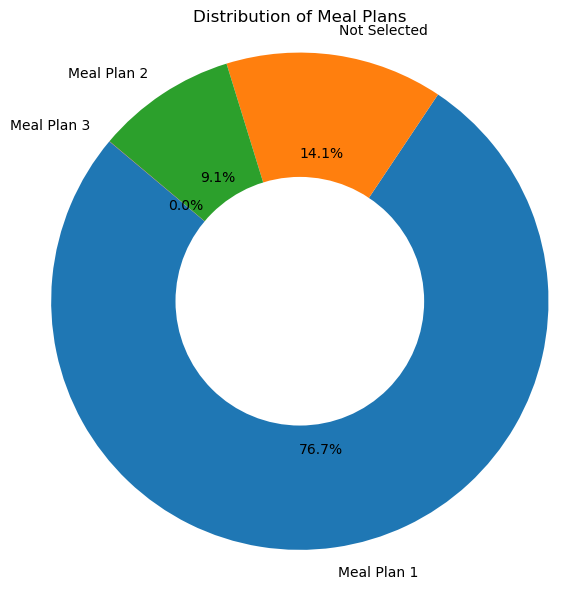

In [24]:

meal_counts = df['type_of_meal_plan'].value_counts()
plt.figure(figsize=(6, 6))
# Create the pie chart
wedges, texts, autotexts = plt.pie(
    meal_counts, labels=meal_counts.index, autopct='%1.1f%%', startangle=140
)
# Draw a white circle at the center to create the donut shape
centre_circle = plt.Circle((0, 0), 0.50, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Distribution of Meal Plans')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.tight_layout()
plt.show()

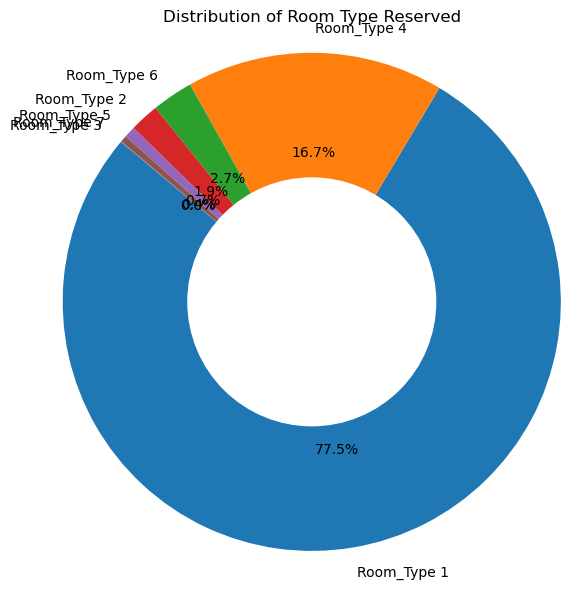

In [25]:

meal_counts = df['room_type_reserved'].value_counts()
plt.figure(figsize=(6, 6))
# Create the pie chart
wedges, texts, autotexts = plt.pie(
    meal_counts, labels=meal_counts.index, autopct='%1.1f%%', startangle=140
)
# Draw a white circle at the center to create the donut shape
centre_circle = plt.Circle((0, 0), 0.50, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Distribution of Room Type Reserved')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.tight_layout()
plt.show()

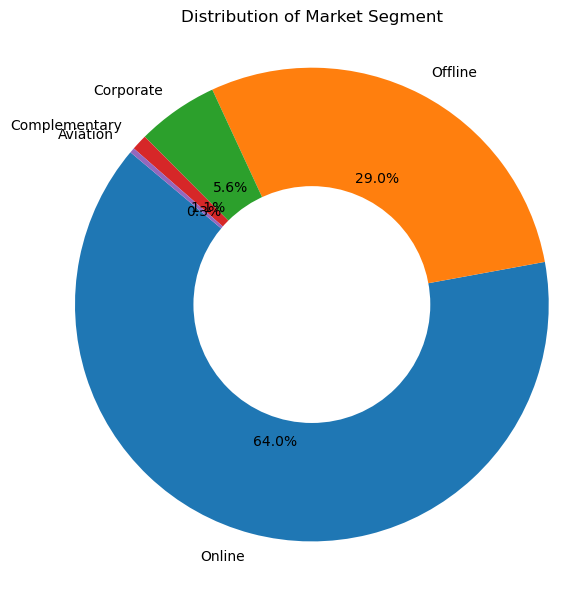

In [26]:
#but look this up, some corpo are also online bookings?

meal_counts = df['market_segment_type'].value_counts()
plt.figure(figsize=(6, 6))
# Create the pie chart
wedges, texts, autotexts = plt.pie(
    meal_counts, labels=meal_counts.index, autopct='%1.1f%%', startangle=140
)
# Draw a white circle at the center to create the donut shape
centre_circle = plt.Circle((0, 0), 0.50, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Distribution of Market Segment')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.tight_layout()
plt.show()

* Children

* Parking space

# Part 2: Modelling

## Steps:
1. Import necessary libraries
2. Load the dataset into a dataframe
3. Standardize the features using Standard Scalar
4. Check the correlation between features without PCA with corr() function
5. Applying Principal Component Analysis
6. Checking correlation between features after PCA

#### Standardize the features using Standard Scalar

In [27]:
# Identify numerical and categorical features
numerical_features = df.select_dtypes(include=np.number).columns.tolist()
categorical_features = df.select_dtypes(include='object').columns.tolist()


In [28]:
categorical_features

['Booking_ID',
 'type_of_meal_plan',
 'room_type_reserved',
 'market_segment_type',
 'booking_status',
 'weekday',
 'stay_duration_status',
 'booking_status_num']

In [29]:
numerical_features

['no_of_adults',
 'no_of_children',
 'no_of_weekend_nights',
 'no_of_week_nights',
 'required_car_parking_space',
 'lead_time',
 'arrival_year',
 'arrival_month',
 'arrival_date',
 'repeated_guest',
 'no_of_previous_cancellations',
 'no_of_previous_bookings_not_canceled',
 'avg_price_per_room',
 'no_of_special_requests',
 'year',
 'month',
 'weekday_num',
 'total_stay_duration',
 'total_previous_bookings',
 'cancel_rate']

In [30]:

# Assume df is your DataFrame and numerical_features is a list of column names
numerical_data = df[numerical_features]  

# Now apply StandardScaler
scaler = StandardScaler()
scaled_data = pd.DataFrame(scaler.fit_transform(numerical_data), columns=numerical_features)


In [31]:
scaled_data

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,required_car_parking_space,lead_time,arrival_year,arrival_month,arrival_date,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,year,month,weekday_num,total_stay_duration,total_previous_bookings,cancel_rate
0,0.298893,-0.26147,0.217401,-0.144803,-0.178819,1.614896,-2.137469,0.839242,-1.555662,-0.16221,-0.063393,-0.087456,-1.095033,-0.788140,-2.137469,0.839242,-1.491882,-0.008412,-0.090467,-0.076622
1,0.298893,-0.26147,1.365993,0.563972,-0.178819,-0.933701,0.467843,1.164990,-1.098013,-0.16221,-0.063393,-0.087456,0.092806,0.483760,0.467843,1.164990,-1.007448,1.111414,-0.090467,-0.076622
2,-1.628975,-0.26147,1.365993,-0.853578,-0.178819,-0.980250,0.467843,-1.766747,1.419055,-0.16221,-0.063393,-0.087456,-1.237528,-0.788140,0.467843,-1.766747,-0.523015,-0.008412,-0.090467,-0.076622
3,0.298893,-0.26147,-0.931190,-0.144803,-0.178819,1.463610,0.467843,-0.789501,0.503757,-0.16221,-0.063393,-0.087456,-0.097567,-0.788140,0.467843,-0.789501,1.414720,-0.568325,-0.090467,-0.076622
4,0.298893,-0.26147,0.217401,-0.853578,-0.178819,-0.433291,0.467843,-1.115250,-0.525952,-0.16221,-0.063393,-0.087456,-0.254312,-0.788140,0.467843,-1.115250,-0.523015,-0.568325,-0.090467,-0.076622
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36270,2.226761,-0.26147,1.365993,2.690296,-0.178819,-0.002706,0.467843,0.187744,-1.441250,-0.16221,-0.063393,-0.087456,1.834665,0.483760,0.467843,0.187744,0.445852,2.791152,-0.090467,-0.076622
36271,0.298893,-0.26147,0.217401,0.563972,-0.178819,1.661446,0.467843,0.839242,0.160521,-0.16221,-0.063393,-0.087456,-0.355483,1.755661,0.467843,0.839242,-0.523015,0.551501,-0.090467,-0.076622
36272,0.298893,-0.26147,1.365993,2.690296,-0.178819,0.730452,0.467843,-0.138004,-1.670074,-0.16221,-0.063393,-0.087456,-0.143451,1.755661,0.467843,-0.138004,1.414720,2.791152,-0.090467,-0.076622
36273,0.298893,-0.26147,-0.931190,0.563972,-0.178819,-0.258730,0.467843,-1.115250,0.618170,-0.16221,-0.063393,-0.087456,-0.254312,-0.788140,0.467843,-1.115250,0.930286,-0.008412,-0.090467,-0.076622


#### Check the correlation between features without PCA with corr() function

<Axes: >

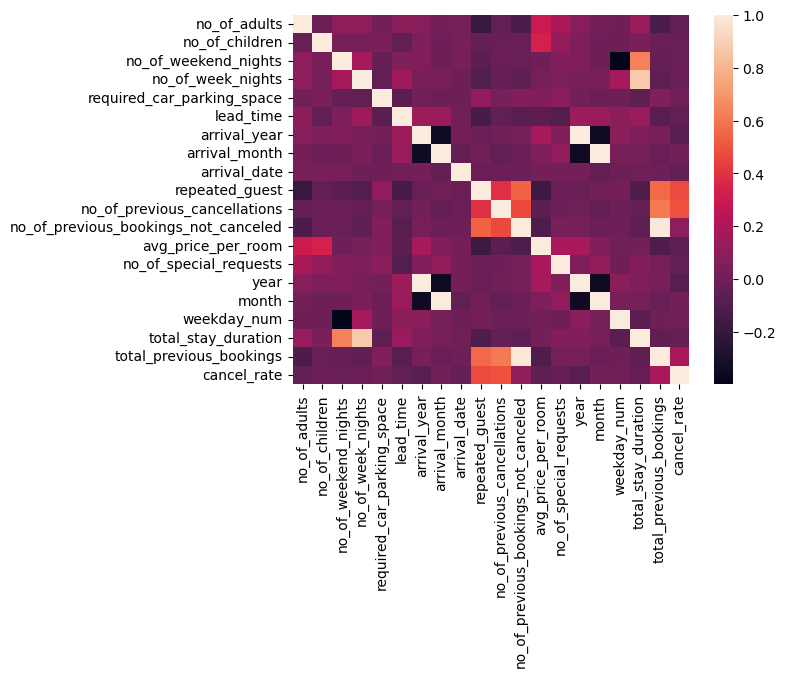

In [32]:
#Check the Co-relation between features without PCA
sns.heatmap(scaled_data.corr())

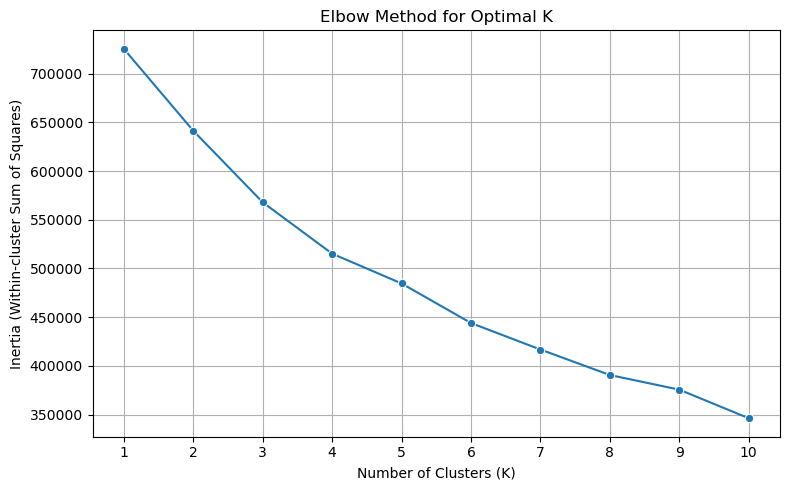

In [55]:

# Elbow Method to determine optimal K
inertia = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)  # <-- fixed here
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

# Plot Elbow Curve
plt.figure(figsize=(8, 5))
sns.lineplot(x=list(K_range), y=inertia, marker='o')
plt.title("Elbow Method for Optimal K")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia (Within-cluster Sum of Squares)")
plt.xticks(K_range)
plt.grid(True)
plt.tight_layout()
plt.show()


#### Applying Principal Component Analysis

In [62]:
#Applying PCA
#Taking no. of Principal Components as 3
pca = PCA(n_components = 3)
pca.fit(scaled_data)
data_pca = pca.transform(scaled_data)
data_pca = pd.DataFrame(data_pca,columns=['PC1','PC2','PC3'])
data_pca.head()

,PC1,PC2,PC3
0,-0.006767,-3.134660,0.307811
1,-0.691921,-0.564982,1.887702
2,0.353145,2.038887,-0.901550
3,-0.167964,1.177209,-1.045736
4,0.070266,1.420890,-1.143151


#### Checking correlation between features after PCA

<Axes: >

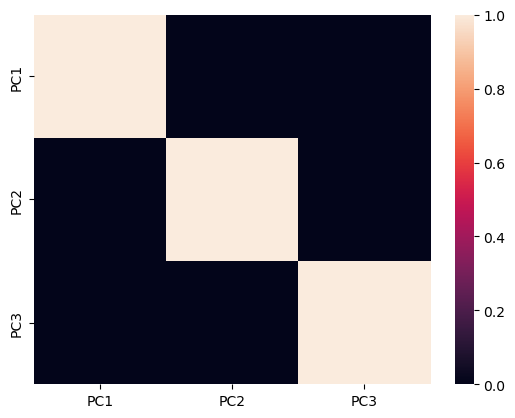

In [63]:
#Checking Co-relation between features after PCA
sns.heatmap(data_pca.corr())

<Axes: xlabel='PC1', ylabel='PC2'>

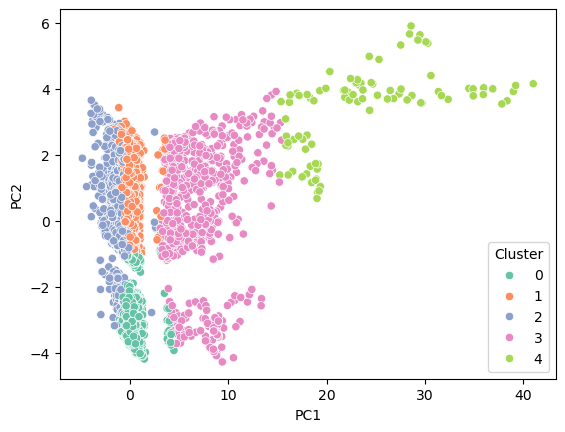

In [71]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=42)
data_pca['Cluster'] = kmeans.fit_predict(data_pca[['PC1', 'PC2', 'PC3']])

# Visualize clusters
import seaborn as sns
sns.scatterplot(data=data_pca, x='PC1', y='PC2', hue='Cluster', palette='Set2')


In [72]:
from sklearn.metrics import silhouette_score
score = silhouette_score(data_pca[['PC1', 'PC2', 'PC3']], data_pca['Cluster'])
print("Silhouette Score:", score)


Silhouette Score: 0.4090864289630377


In [73]:
#1.1. Add cluster labels back to original dataset
df['Cluster'] = data_pca['Cluster']  # Add cluster label to original features


In [74]:
#2. Get summary statistics per cluster
cluster_summary = df.groupby('Cluster').mean(numeric_only=True)
display(cluster_summary)


,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,required_car_parking_space,lead_time,arrival_year,arrival_month,arrival_date,repeated_guest,...,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,was_capped,year,month,weekday_num,total_stay_duration,total_previous_bookings,cancel_rate
Cluster,,,,,,,,,,,,,,,,,,,,,
0,1.757962,0.059843,0.621686,1.922086,0.025774,60.138202,2017.094949,9.887720,14.976744,0.005925,...,0.005925,89.261555,0.528959,0.000000,2017.094949,9.887720,2.764479,2.543771,0.005925,0.000000
1,1.808932,0.106149,0.540794,1.691322,0.034781,76.810852,2018.000000,5.758286,15.926204,0.001016,...,0.001016,106.224917,0.529784,0.001750,2018.000000,5.758286,3.320818,2.232116,0.001016,0.000000
2,2.006302,0.139282,1.393826,3.278747,0.017901,120.023838,2017.978628,8.607453,15.522696,0.000731,...,0.000913,110.699857,0.825738,0.000274,2017.978628,8.607453,2.868207,4.672573,0.000913,0.000000
3,1.206806,0.013089,0.410995,1.280105,0.162304,12.839005,2017.777487,7.503927,14.660995,1.000000,...,3.938482,64.966217,0.517016,0.003927,2017.777487,7.503927,3.379581,1.691099,4.350785,0.192260
4,1.310000,0.000000,0.590000,1.530000,0.140000,14.710000,2018.000000,5.800000,14.450000,1.000000,...,24.880000,60.476900,0.880000,0.000000,2018.000000,5.800000,2.500000,2.120000,30.200000,0.259032


In [77]:

cluster_summary.to_csv("cluster_summary.csv")


In [39]:
df['Cluster'].value_counts()  # Cluster sizes


Cluster
1    17711
2    10949
0     6751
3      764
4      100
Name: count, dtype: int64

In [76]:
df.to_csv("clustered_hotel_bookings.csv", index=False)


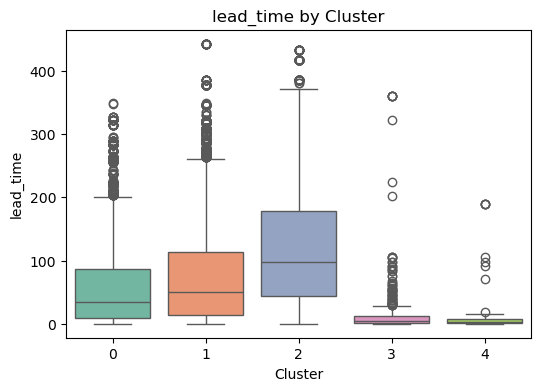

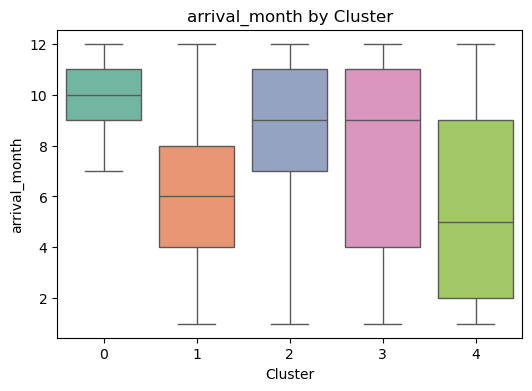

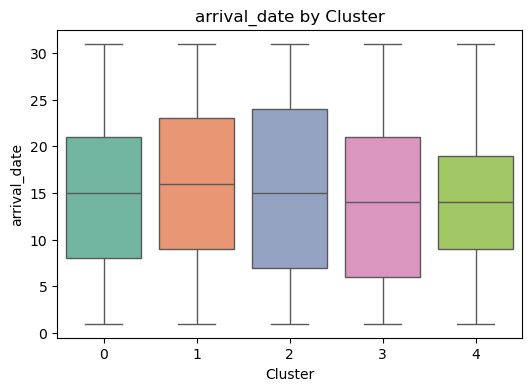

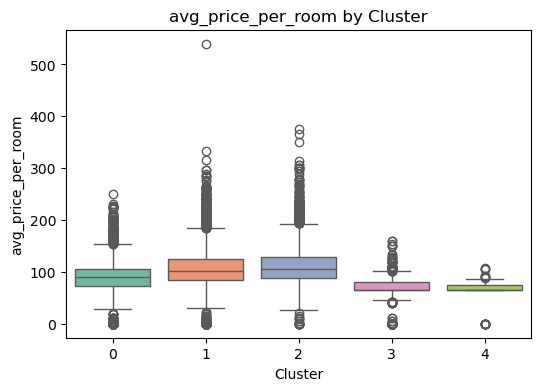

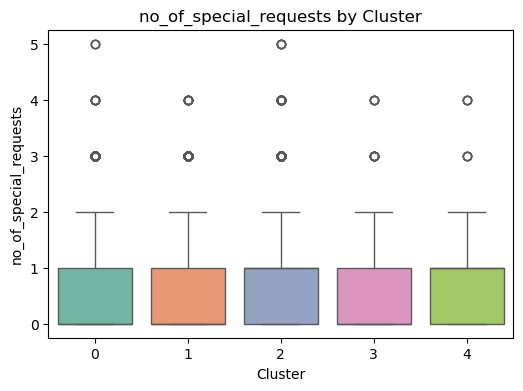

In [41]:
#distreibution difference
#import seaborn as sns
#import matplotlib.pyplot as plt

features = ['lead_time', 'arrival_month', 'arrival_date', 'avg_price_per_room', 'no_of_special_requests']

for feature in features:
    plt.figure(figsize=(6,4))
    sns.boxplot(data=df, x='Cluster', y=feature, hue='Cluster', palette='Set2', legend=False)
    plt.title(f'{feature} by Cluster')
    plt.show()


<Axes: xlabel='Cluster'>

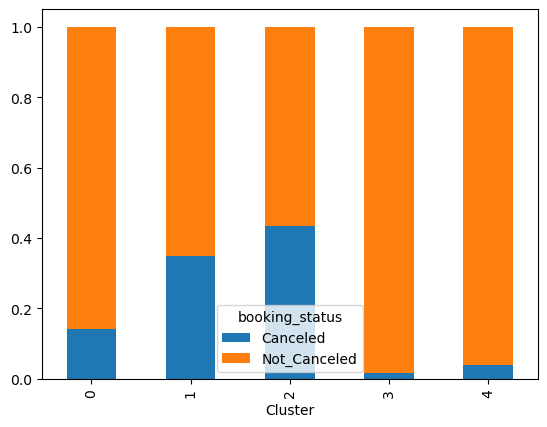

In [42]:
# Example: Booking status by cluster
pd.crosstab(df['Cluster'], df['booking_status'], normalize='index').plot(kind='bar', stacked=True)


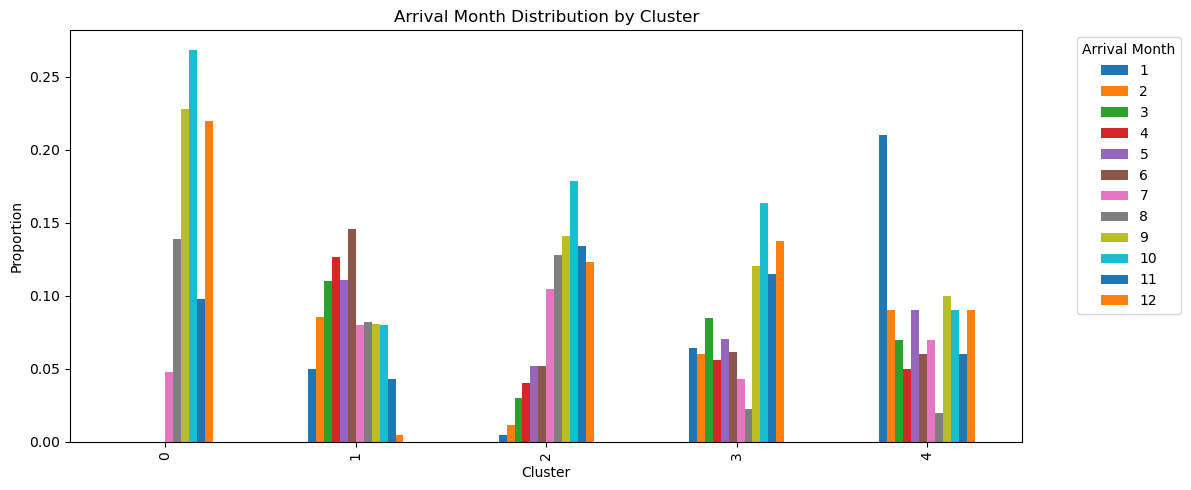

In [43]:
# Example: Booking status by cluster
#pd.crosstab(df['Cluster'], df['arrival_month'], normalize='index').plot(kind='bar', stacked=False)


import matplotlib.pyplot as plt

# Set wider figure
plt.figure(figsize=(12, 5))  # increase width here (12)

# Plot
pd.crosstab(df['Cluster'], df['arrival_month'], normalize='index') \
  .plot(kind='bar', stacked=False, ax=plt.gca())

plt.title('Arrival Month Distribution by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Proportion')
plt.legend(title='Arrival Month', bbox_to_anchor=(1.05, 1), loc='upper left')  # move legend outside if needed
plt.tight_layout()
plt.show()


In [37]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

# Drop unneeded columns
df_cluster = df.drop(columns=["Booking_ID", "weekday", "no_of_weekend_nights","no_of_week_nights","cancel_rate"])

# Dynamically identify features
numerical_features = df_cluster.select_dtypes(include=np.number).columns.tolist()
categorical_features = df_cluster.select_dtypes(include='object').columns.tolist()

# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# Fit + transform
X_processed = preprocessor.fit_transform(df_cluster)

# Recover column names
ohe = preprocessor.named_transformers_['cat']
ohe_feature_names = ohe.get_feature_names_out(categorical_features)
all_feature_names = numerical_features + list(ohe_feature_names)

# Convert to DataFrame
import pandas as pd
from scipy.sparse import issparse

if issparse(X_processed):
    X_processed = X_processed.toarray()

df_processed = pd.DataFrame(X_processed, columns=all_feature_names)
#df_processed.head()
df_scaled = df_processed
df_scaled.head()

,no_of_adults,no_of_children,required_car_parking_space,lead_time,arrival_year,arrival_month,arrival_date,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,...,market_segment_type_Complementary,market_segment_type_Corporate,market_segment_type_Offline,market_segment_type_Online,booking_status_Canceled,booking_status_Not_Canceled,stay_duration_status_long_stay,stay_duration_status_short_stay,booking_status_num_0,booking_status_num_1
0,0.298893,-0.26147,-0.178819,1.614896,-2.137469,0.839242,-1.555662,-0.16221,-0.063393,-0.087456,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
1,0.298893,-0.26147,-0.178819,-0.933701,0.467843,1.164990,-1.098013,-0.16221,-0.063393,-0.087456,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
2,-1.628975,-0.26147,-0.178819,-0.980250,0.467843,-1.766747,1.419055,-0.16221,-0.063393,-0.087456,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0
3,0.298893,-0.26147,-0.178819,1.463610,0.467843,-0.789501,0.503757,-0.16221,-0.063393,-0.087456,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0
4,0.298893,-0.26147,-0.178819,-0.433291,0.467843,-1.115250,-0.525952,-0.16221,-0.063393,-0.087456,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0


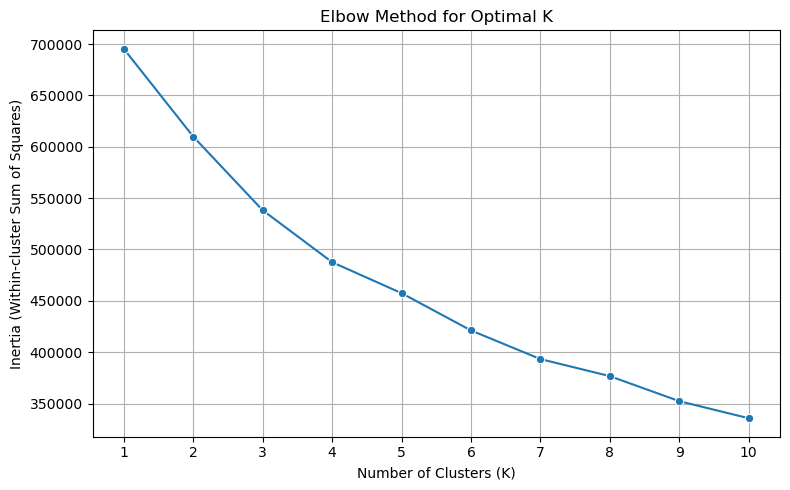

In [38]:

# Elbow Method to determine optimal K
inertia = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)  # <-- fixed here
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)

# Plot Elbow Curve
plt.figure(figsize=(8, 5))
sns.lineplot(x=list(K_range), y=inertia, marker='o')
plt.title("Elbow Method for Optimal K")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia (Within-cluster Sum of Squares)")
plt.xticks(K_range)
plt.grid(True)
plt.tight_layout()
plt.show()


Silhouette Score for K=5: 0.1530


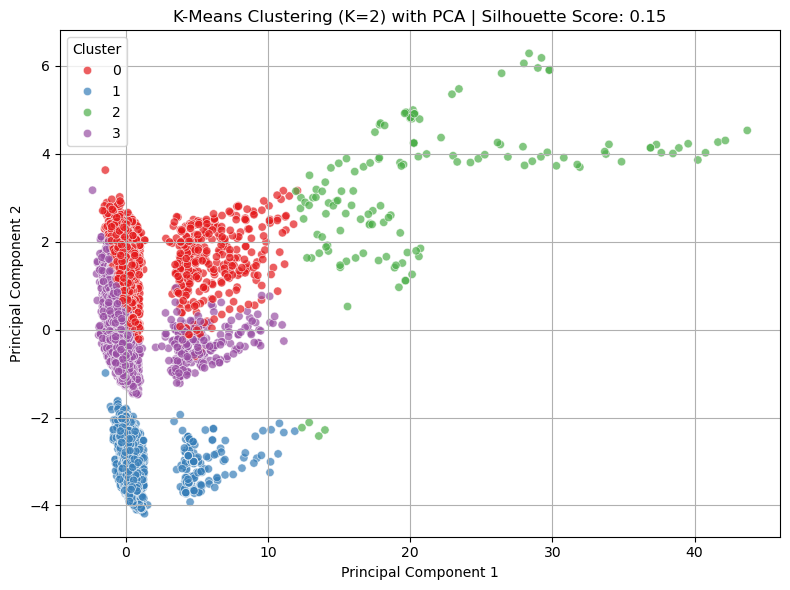

In [40]:
# Apply KMeans clustering with K=5
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(df_scaled)

# Evaluate with Silhouette Score
sil_score = silhouette_score(df_scaled, cluster_labels)
print(f"Silhouette Score for K=5: {sil_score:.4f}")

# Reduce dimensions using PCA for visualization
pca = PCA(n_components=2, random_state=42)
pca_components = pca.fit_transform(df_scaled)

# Create DataFrame for plotting
plot_df = pd.DataFrame(pca_components, columns=["PC1", "PC2"])
plot_df["Cluster"] = cluster_labels

# Plot clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(data=plot_df, x="PC1", y="PC2", hue="Cluster", palette="Set1", alpha=0.7)
plt.title(f"K-Means Clustering (K=2) with PCA | Silhouette Score: {sil_score:.2f}")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.grid(True)
plt.tight_layout()
plt.show()


In [113]:
# KMeans clustering with K=2
kmeans_k2 = KMeans(n_clusters=2, random_state=42, n_init=10)
cluster_labels_k2 = kmeans_k2.fit_predict(df_scaled)

# Attach labels to PCA DataFrame
df_profile_k2 = pd.DataFrame(pca_components, columns=["PC1", "PC2"])
df_profile_k2["Cluster"] = cluster_labels_k2

# Compute cluster-wise averages on the original scaled+encoded data
df_scaled_with_cluster = df_scaled.copy()
df_scaled_with_cluster["Cluster"] = cluster_labels_k2

cluster_summary_k2 = df_scaled_with_cluster.groupby("Cluster").mean().round(2)

# Optional: Save summary
cluster_summary_k2.to_csv("cluster_k2_profile_summary.csv")

key_features = [
    'no_of_adults',
    'no_of_children',
    'no_of_weekend_nights',
    'no_of_week_nights',
    'required_car_parking_space',
    'lead_time',
    'arrival_year',
    'arrival_month',
    'arrival_date',
    'repeated_guest',
    'room_type_reserved_Room_Type 1',
    'room_type_reserved_Room_Type 2',
    'room_type_reserved_Room_Type 3',
    'room_type_reserved_Room_Type 4',
    'room_type_reserved_Room_Type 5',
    'room_type_reserved_Room_Type 6',
    'room_type_reserved_Room_Type 7',
    'market_segment_type_Aviation',
    'market_segment_type_Complementary',
    'market_segment_type_Corporate',
    'market_segment_type_Offline',
    'market_segment_type_Online',
    'booking_status_Canceled',
    'booking_status_Not_Canceled',
    'stay_type_Weekday',
    'stay_type_Weekend'
]

# Select key features
print(cluster_summary_k2[key_features])


KeyError: "['stay_type_Weekday', 'stay_type_Weekend'] not in index"

In [ ]:
print(cluster_summary_k2.columns.tolist())


In [ ]:
print(df_profile_k2['Cluster'].value_counts())


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get only numeric columns
numeric_df = df.select_dtypes(include='number')

# Compute correlation matrix
corr_matrix = numeric_df.corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Matrix')
plt.show()
